In [13]:
import torch as th

from torchvision import transforms
from torchvision.models import alexnet

In [14]:
from src.dataloader import customDataloader
from src.utils import train_loop, test_model, init_weights
from src.plots import plot_statistics
from models.model import Model

# Exercise 1

In [63]:
transform = None

In [64]:
train_loader, validation_loader, test_loader = customDataloader(transform=[transform, transform], batch_size=32, shuffle=True)

In [65]:
model = Model()
model.net.apply(init_weights)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), lr=1e-3, momentum=0.5)

In [66]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)

 49%|███████▎       | 49/100 [00:05<00:06,  8.49it/s, Train Loss=1.03, Test Loss=2.19, Train Acc=0.653, Test Acc=0.324]

Stopped early, epoch: 49


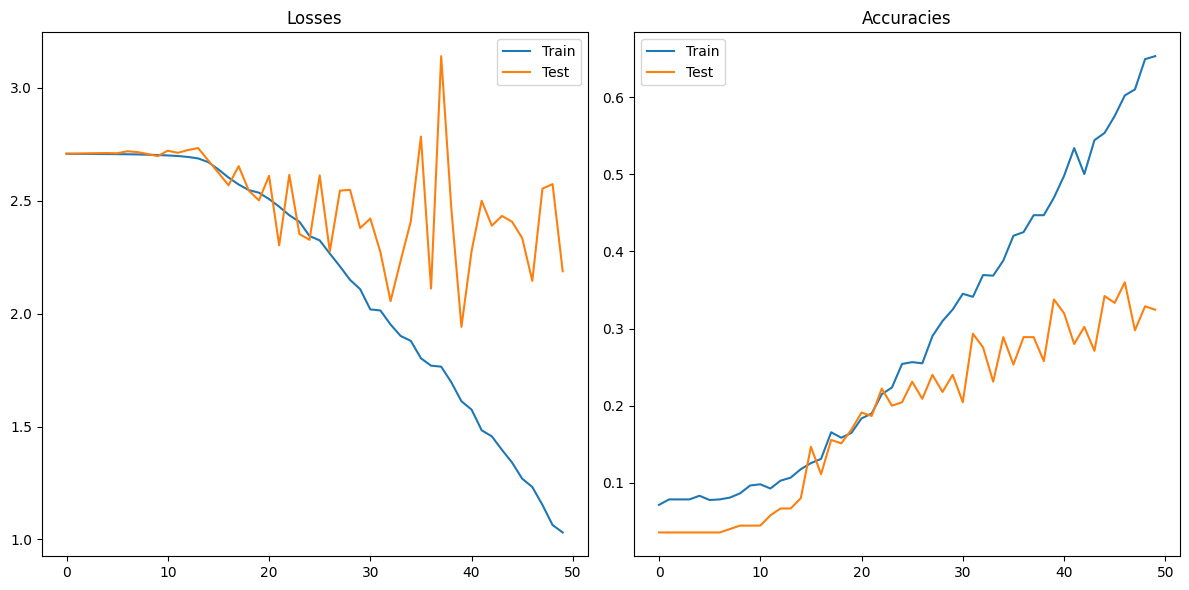

In [67]:
plot_statistics(statistics)

Test Loss: 2.4496870040893555
Test Accuracy: 0.3370184302330017


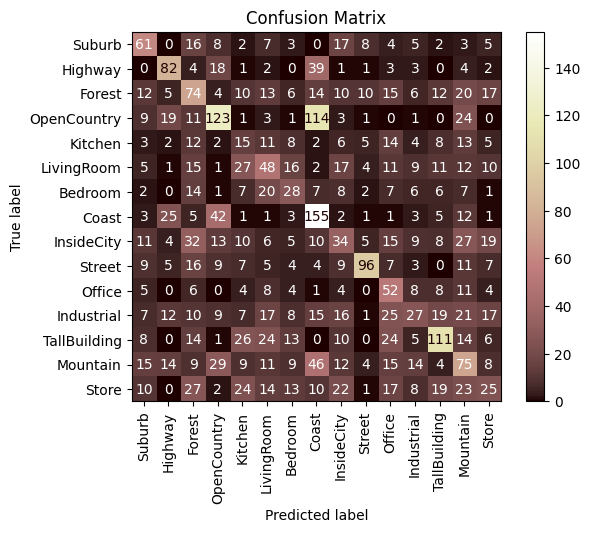

In [68]:
test_model(model, test_loader, criterion)

# Exercise 2

In [69]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
])
test_transform = None

In [70]:
train_loader, validation_loader, test_loader = customDataloader(transform=[transform, test_transform], batch_size=32, shuffle=True)

## Horizontal Flip

In [23]:
model = Model()
model.net.apply(init_weights)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), momentum=0.5)

In [24]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)

 64%|█████████▌     | 64/100 [00:10<00:05,  6.00it/s, Train Loss=1.11, Test Loss=1.89, Train Acc=0.642, Test Acc=0.444]

Stopped early, epoch: 64


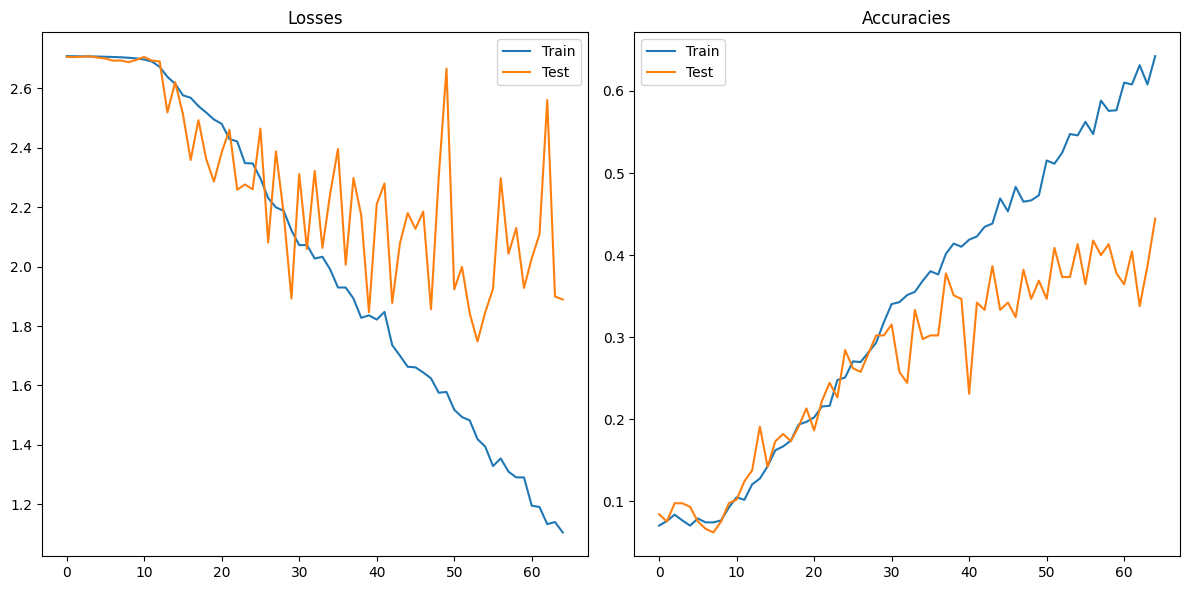

In [25]:
plot_statistics(statistics)

Test Loss: 2.1656227111816406
Test Accuracy: 0.39430487155914307


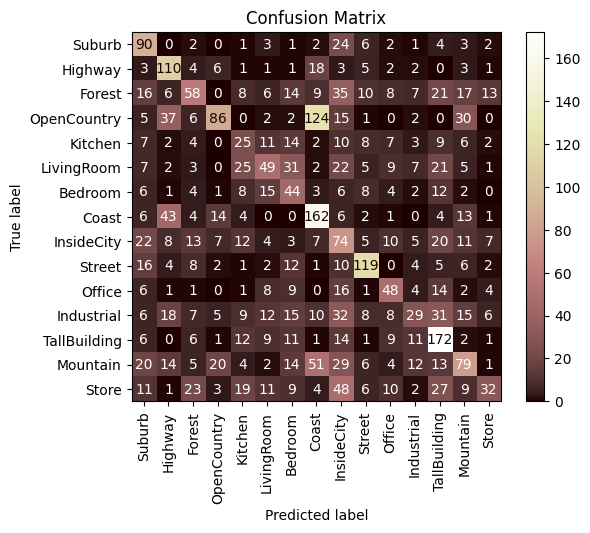

In [26]:
test_model(model, test_loader, criterion)

## Batch Normalization
Kernel Size = 3


In [71]:
model = Model(normalization=True)
model.net.apply(init_weights)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), momentum=0.5)

In [72]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)

 36%|█████         | 36/100 [00:06<00:12,  5.30it/s, Train Loss=0.624, Test Loss=2.19, Train Acc=0.839, Test Acc=0.284]

Stopped early, epoch: 36


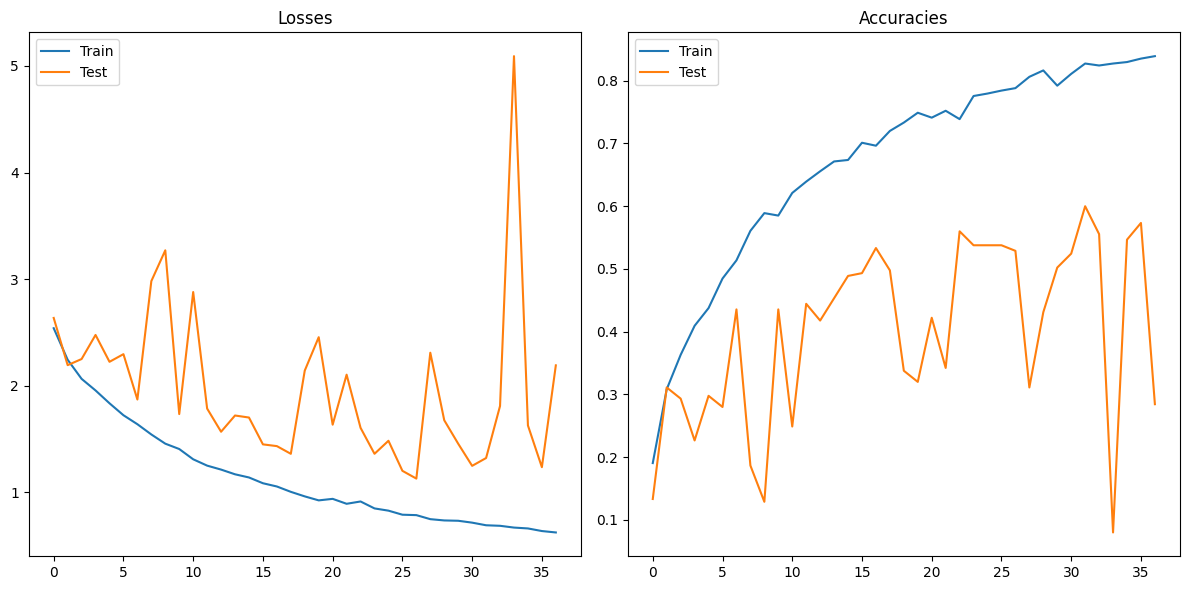

In [73]:
plot_statistics(statistics)

Test Loss: 2.318239450454712
Test Accuracy: 0.3172529339790344


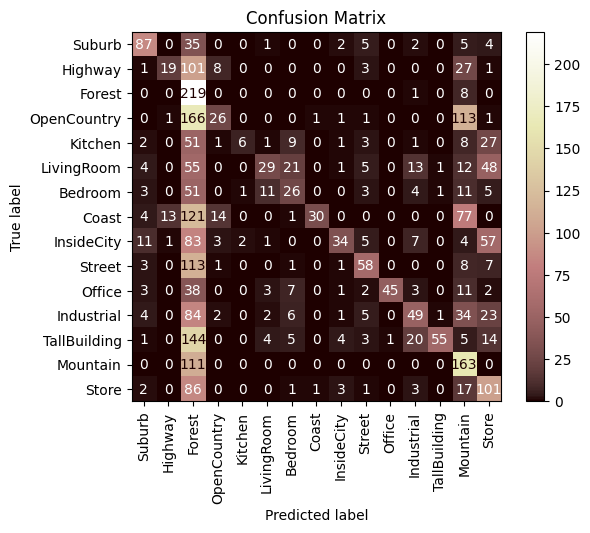

In [74]:
test_model(model, test_loader, criterion)

## Batch Normalization 
Kernel Size = 5

In [31]:
model = Model(kernel_size=5, normalization=True)
model.net.apply(init_weights)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), momentum=0.5)

In [32]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)

 63%|█████████▍     | 63/100 [00:12<00:07,  5.15it/s, Train Loss=0.358, Test Loss=1.86, Train Acc=0.94, Test Acc=0.649]

Stopped early, epoch: 63


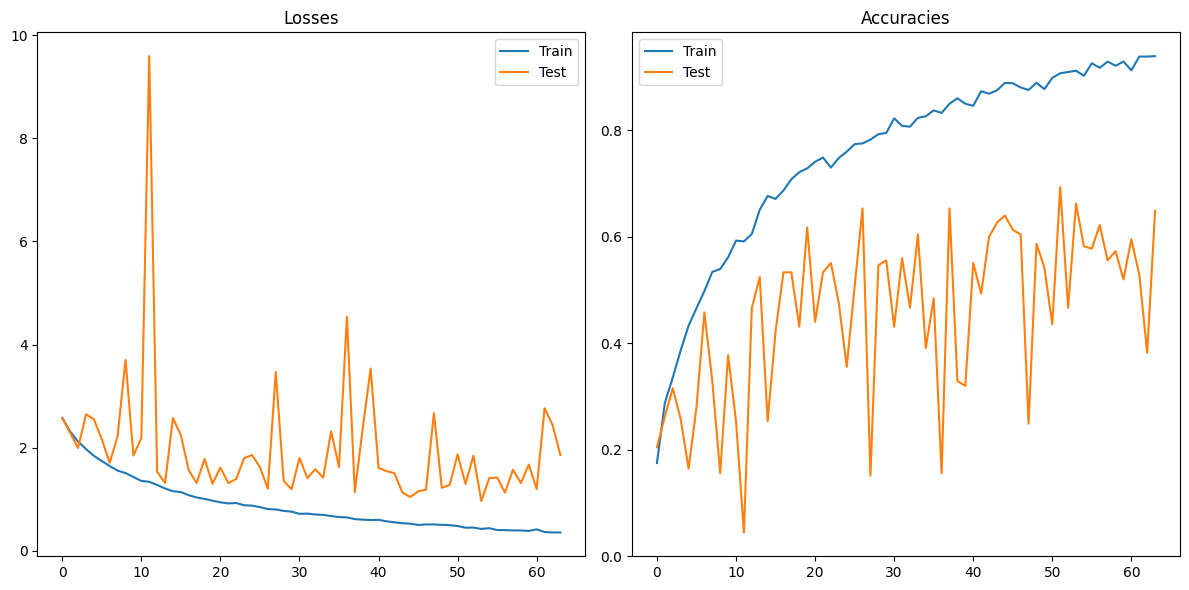

In [33]:
plot_statistics(statistics)

Test Loss: 1.153567910194397
Test Accuracy: 0.6140703558921814


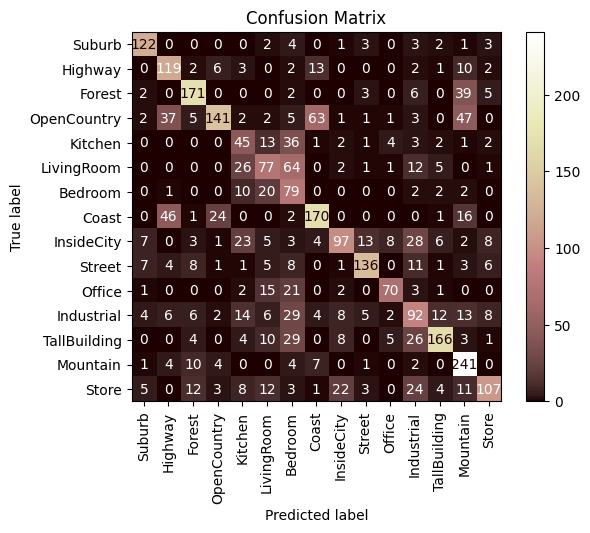

In [34]:
test_model(model, test_loader, criterion)

## Batch Normalization 
Kernel Size = 7

In [35]:
model = Model(kernel_size=7, normalization=True)
model.net.apply(init_weights)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.SGD(model.parameters(), momentum=0.5)

In [36]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)

 41%|█████▋        | 41/100 [00:08<00:11,  5.04it/s, Train Loss=0.541, Test Loss=1.46, Train Acc=0.884, Test Acc=0.542]

Stopped early, epoch: 41


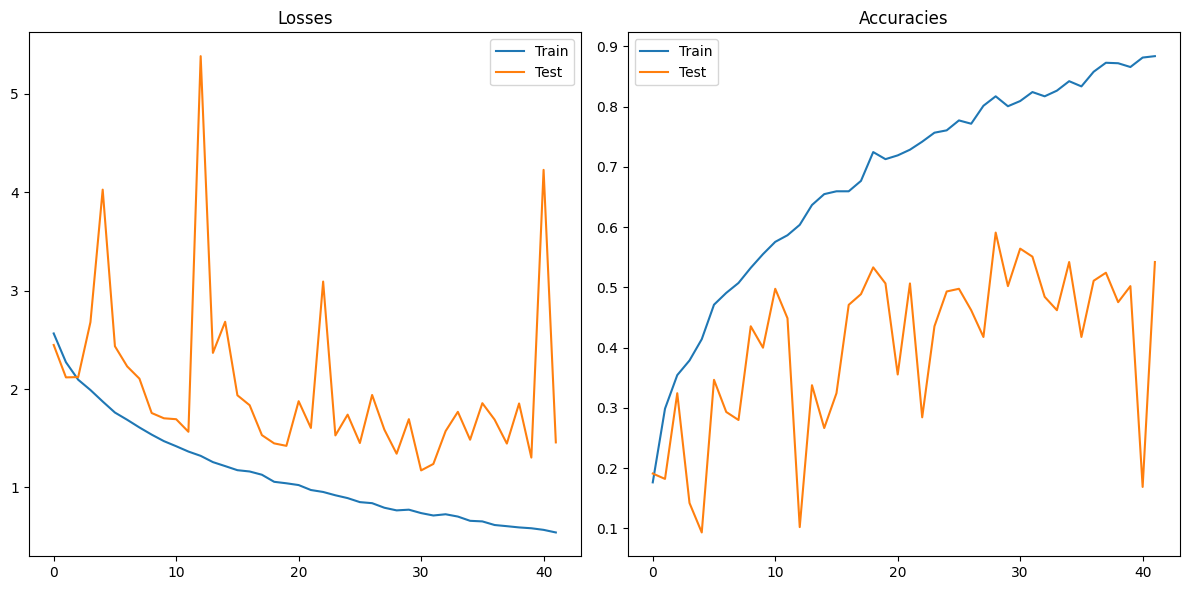

In [37]:
plot_statistics(statistics)

Test Loss: 1.6656759977340698
Test Accuracy: 0.4519262909889221


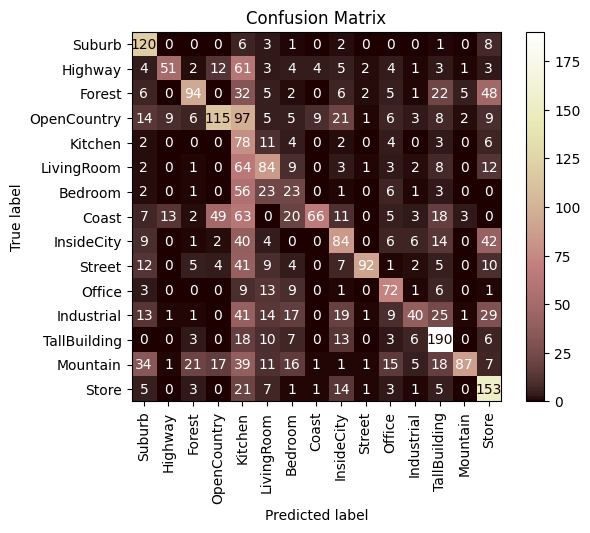

In [38]:
test_model(model, test_loader, criterion)

## Batch Normalization + Adam
Kernel Size = 3


In [39]:
model = Model(kernel_size=3, normalization=True)
model.net.apply(init_weights)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters())

In [40]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)

 25%|███▌          | 25/100 [00:04<00:14,  5.01it/s, Train Loss=0.183, Test Loss=1.38, Train Acc=0.958, Test Acc=0.609]

Stopped early, epoch: 25


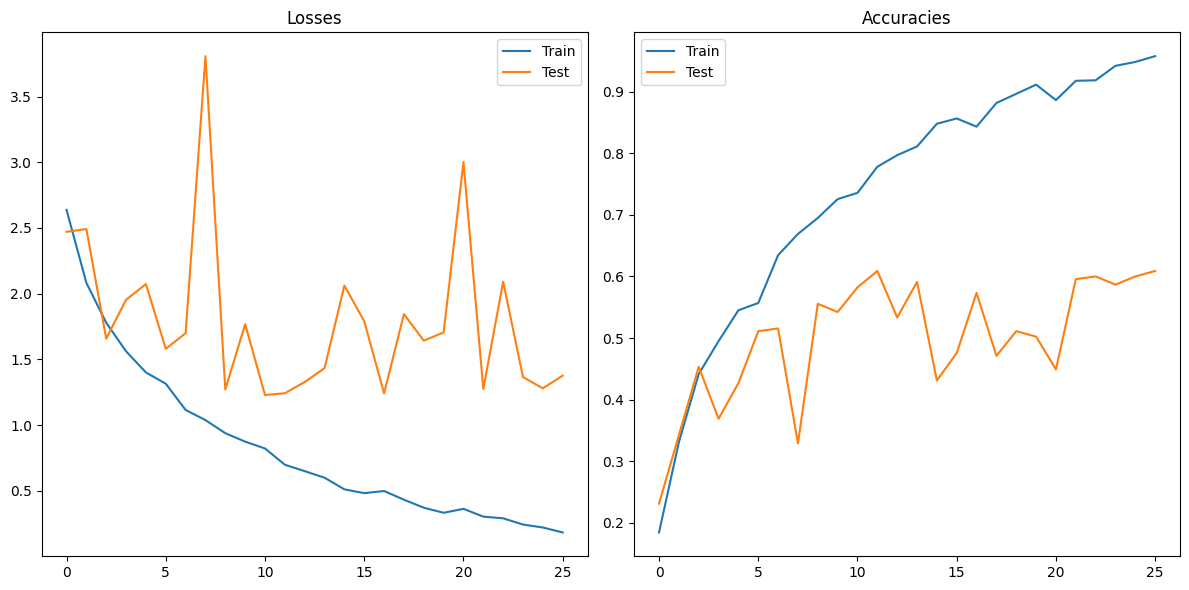

In [41]:
plot_statistics(statistics)

Test Loss: 1.5369846820831299
Test Accuracy: 0.5802345275878906


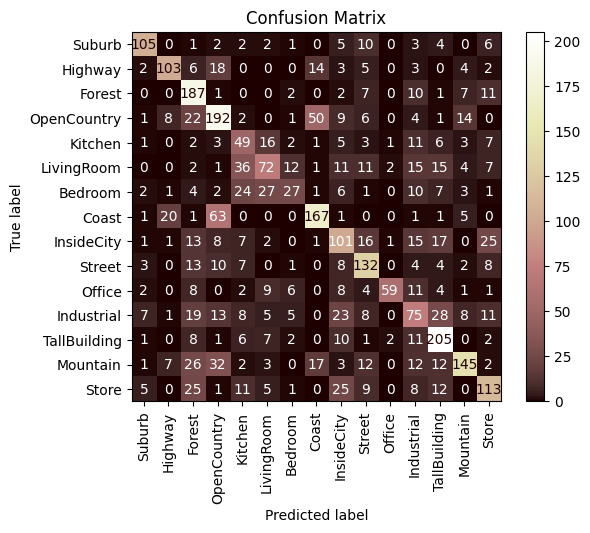

In [42]:
test_model(model, test_loader, criterion)

## Batch Normalization + Adam + Dropout
Kernel Size = 3


In [75]:
model = Model(kernel_size=3, normalization=True, dropout=True)
model.net.apply(init_weights)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters())

In [76]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)

 24%|███▎          | 24/100 [00:04<00:15,  4.82it/s, Train Loss=0.906, Test Loss=3.01, Train Acc=0.704, Test Acc=0.107]

Stopped early, epoch: 24


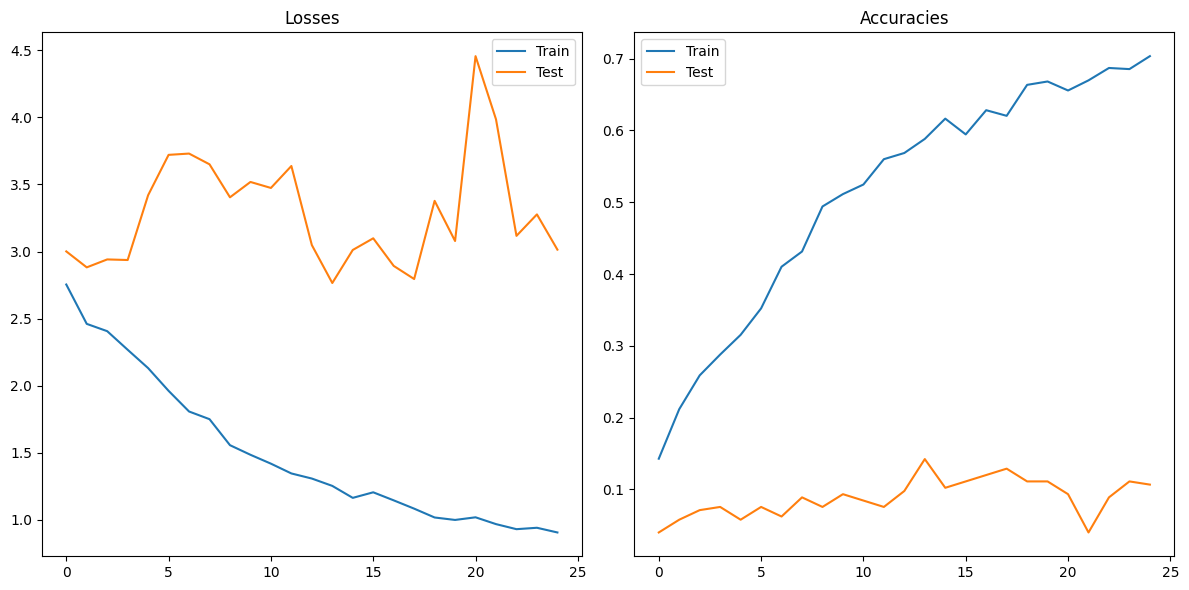

In [77]:
plot_statistics(statistics)

Test Loss: 2.91782283782959
Test Accuracy: 0.15644891560077667


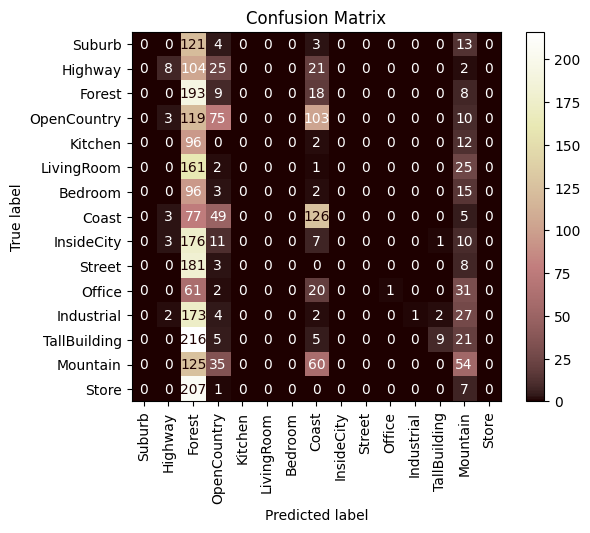

In [78]:
test_model(model, test_loader, criterion)

## Batch Normalization + Adam + Ensemble
Kernel Size = 3


In [47]:
models = []

for _ in range(10):
    model = Model(kernel_size=3, normalization=True)
    model.net.apply(init_weights)

    models.append(model)

criterion = th.nn.CrossEntropyLoss()

In [48]:
statistics = []
for i, model in enumerate(models):
    print(f"Model {i}")
    optimizer = th.optim.Adam(model.parameters())
        
    statistic = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)
    statistics.append(statistic)

Model 0


 21%|██▉           | 21/100 [00:04<00:15,  4.97it/s, Train Loss=0.183, Test Loss=3.08, Train Acc=0.961, Test Acc=0.502]


Stopped early, epoch: 21
Model 1


 24%|███▊            | 24/100 [00:04<00:15,  5.02it/s, Train Loss=0.157, Test Loss=1.65, Train Acc=0.964, Test Acc=0.6]


Stopped early, epoch: 24
Model 2


 21%|██▉           | 21/100 [00:04<00:16,  4.88it/s, Train Loss=0.211, Test Loss=1.36, Train Acc=0.948, Test Acc=0.604]


Stopped early, epoch: 21
Model 3


 23%|███▏          | 23/100 [00:04<00:15,  5.00it/s, Train Loss=0.196, Test Loss=2.01, Train Acc=0.951, Test Acc=0.502]


Stopped early, epoch: 23
Model 4


 33%|████▎        | 33/100 [00:06<00:13,  5.06it/s, Train Loss=0.0548, Test Loss=1.57, Train Acc=0.997, Test Acc=0.644]


Stopped early, epoch: 33
Model 5


 24%|███▎          | 24/100 [00:04<00:15,  5.01it/s, Train Loss=0.143, Test Loss=1.61, Train Acc=0.973, Test Acc=0.653]


Stopped early, epoch: 24
Model 6


 34%|████▍        | 34/100 [00:06<00:13,  5.07it/s, Train Loss=0.0566, Test Loss=2.76, Train Acc=0.995, Test Acc=0.529]


Stopped early, epoch: 34
Model 7


 17%|██▍           | 17/100 [00:03<00:16,  4.92it/s, Train Loss=0.294, Test Loss=1.61, Train Acc=0.915, Test Acc=0.564]


Stopped early, epoch: 17
Model 8


 20%|██▊           | 20/100 [00:04<00:16,  4.98it/s, Train Loss=0.281, Test Loss=1.98, Train Acc=0.928, Test Acc=0.533]


Stopped early, epoch: 20
Model 9


 22%|███           | 22/100 [00:04<00:15,  5.00it/s, Train Loss=0.198, Test Loss=2.11, Train Acc=0.962, Test Acc=0.591]

Stopped early, epoch: 22


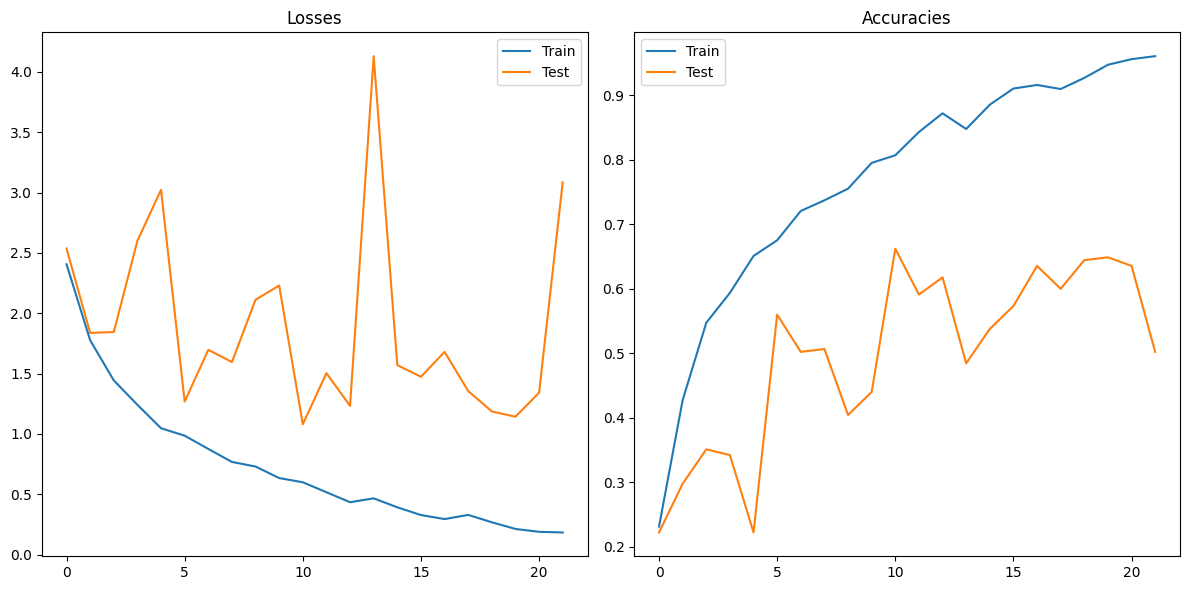

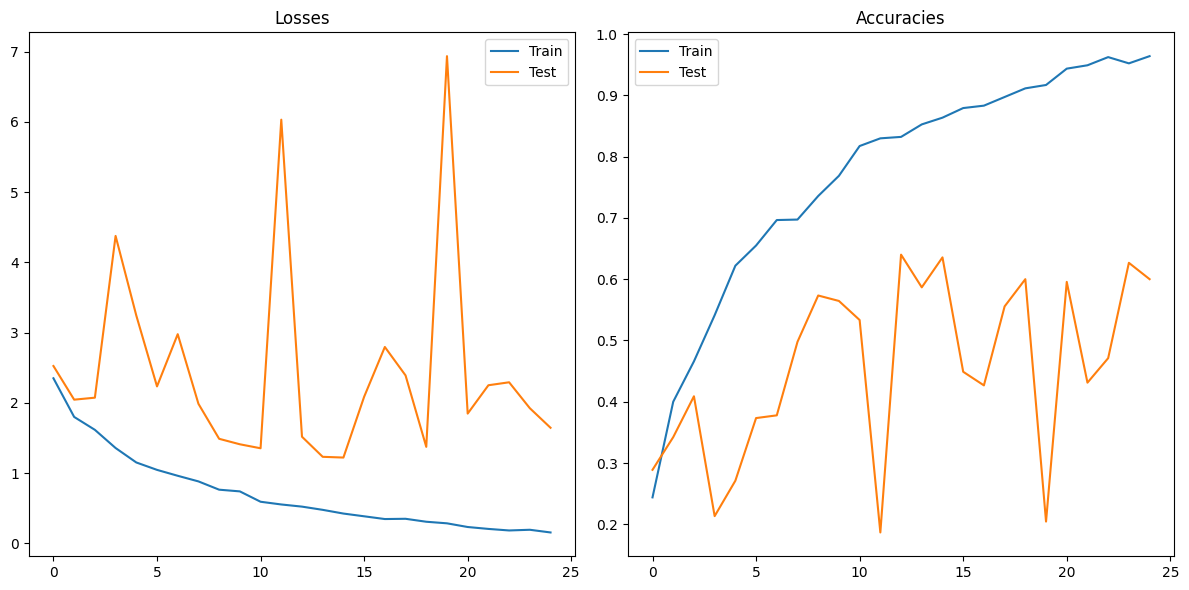

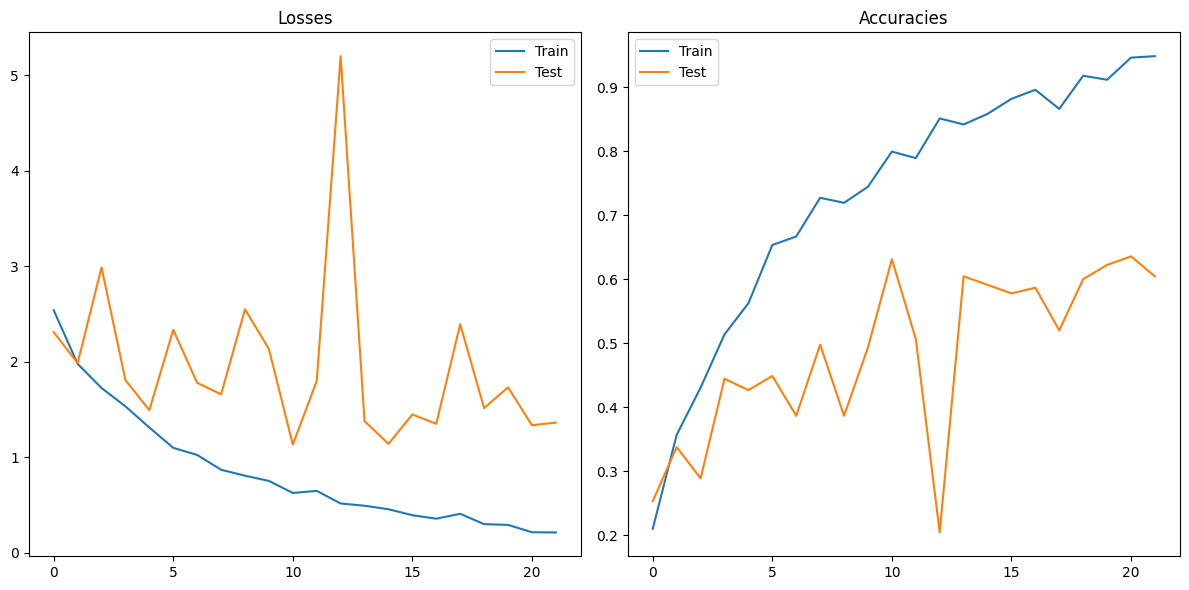

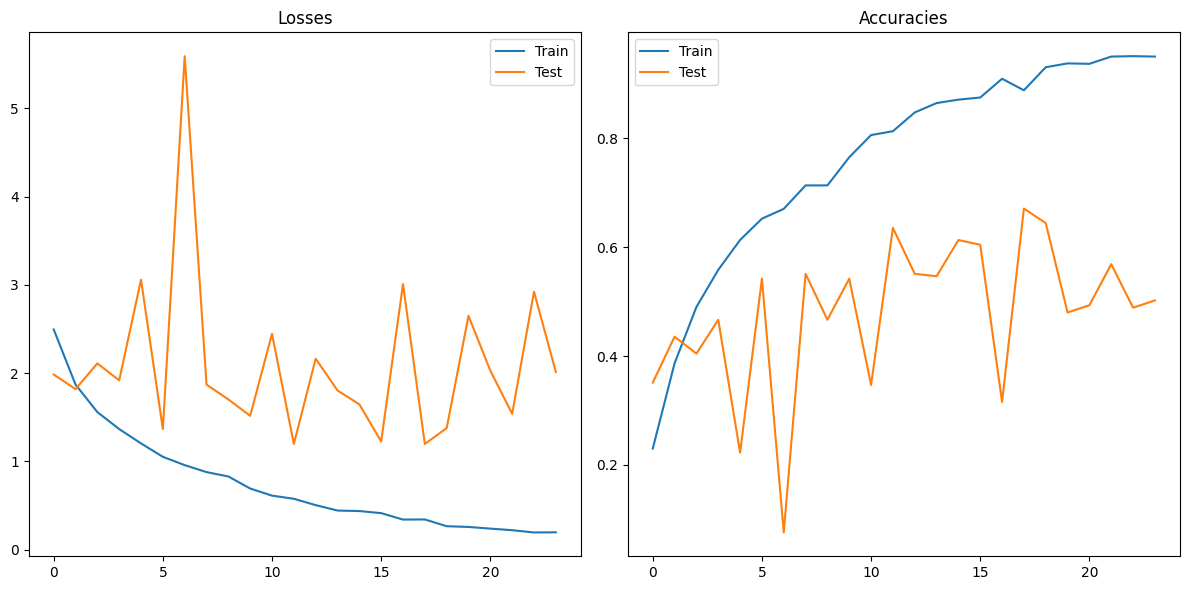

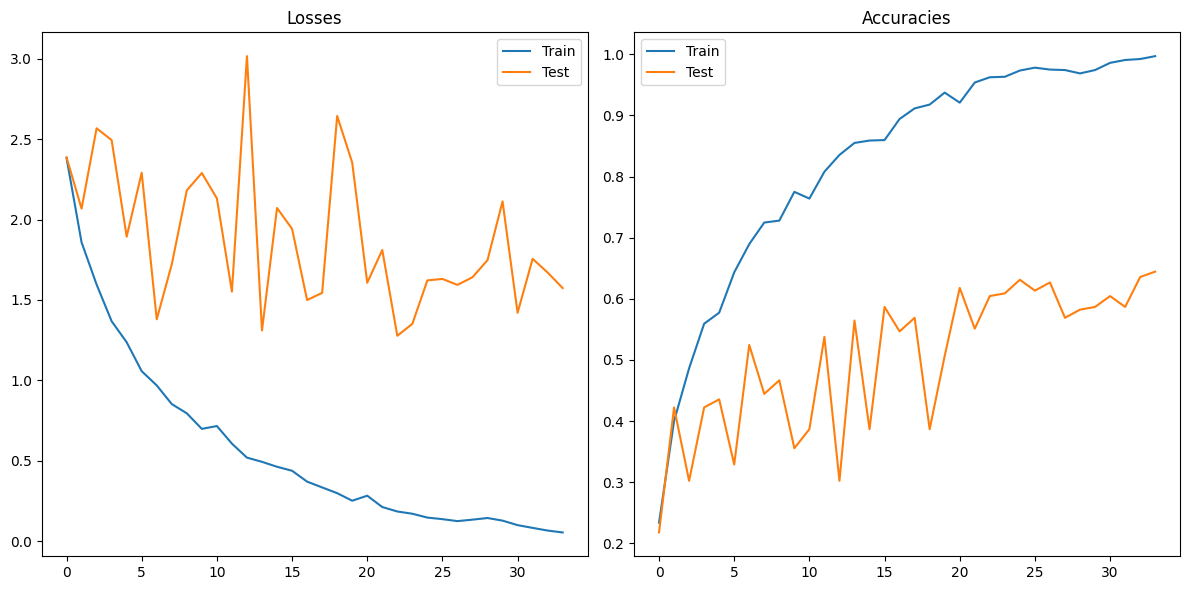

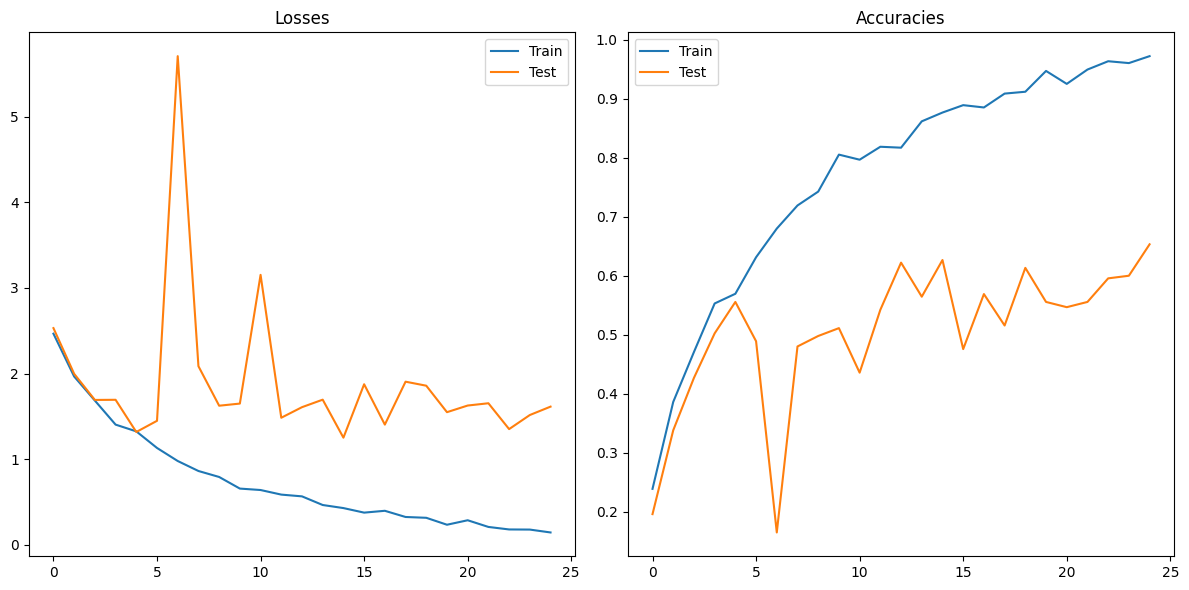

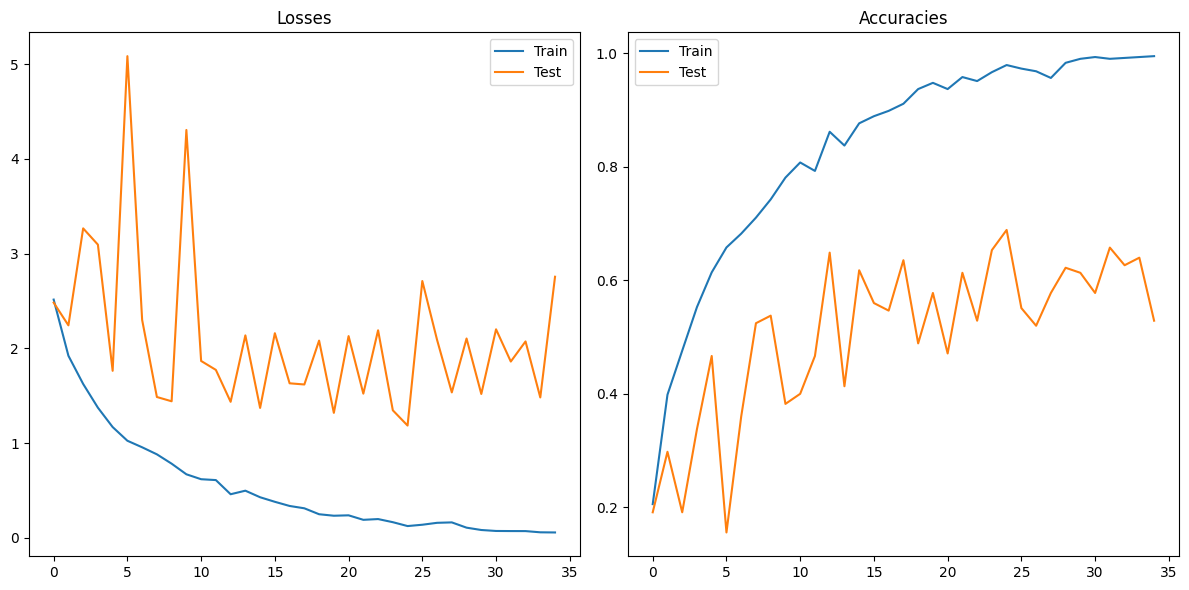

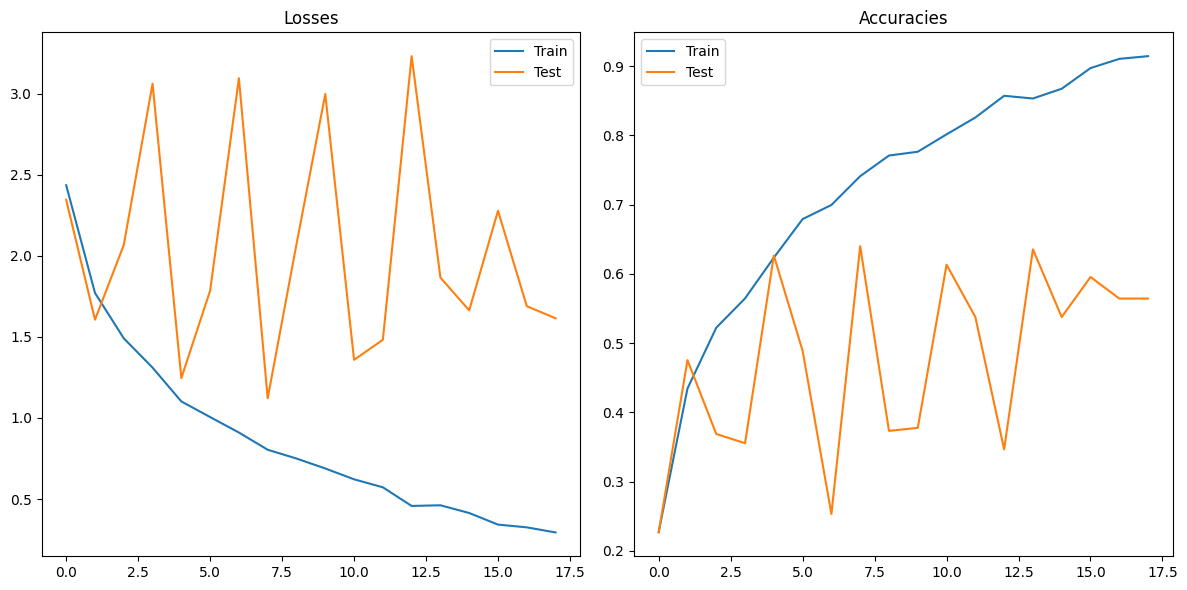

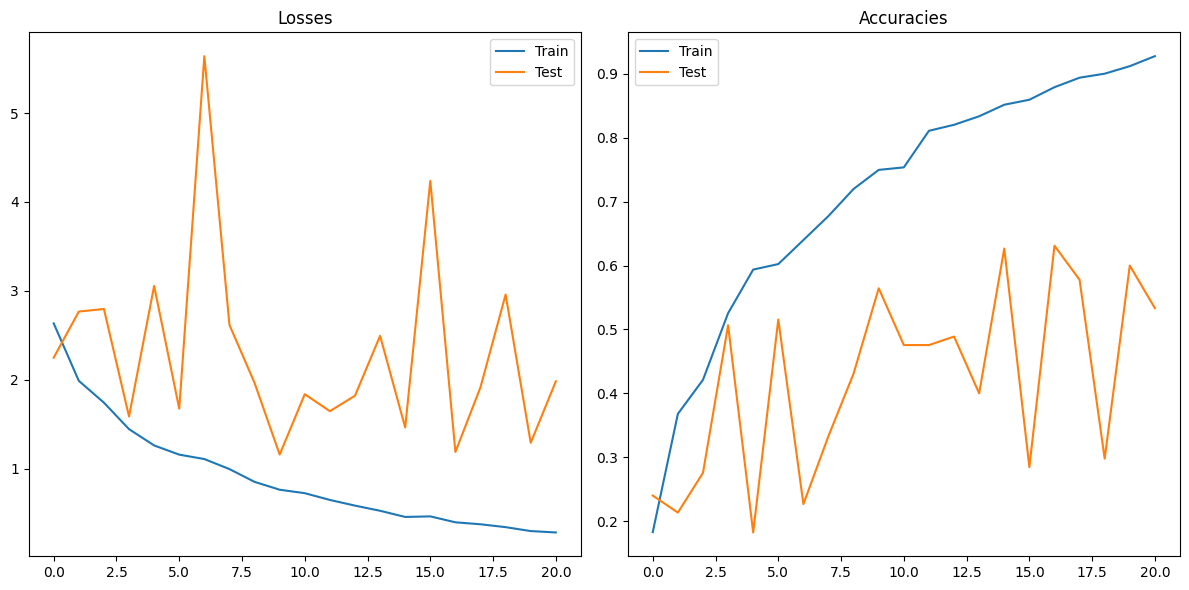

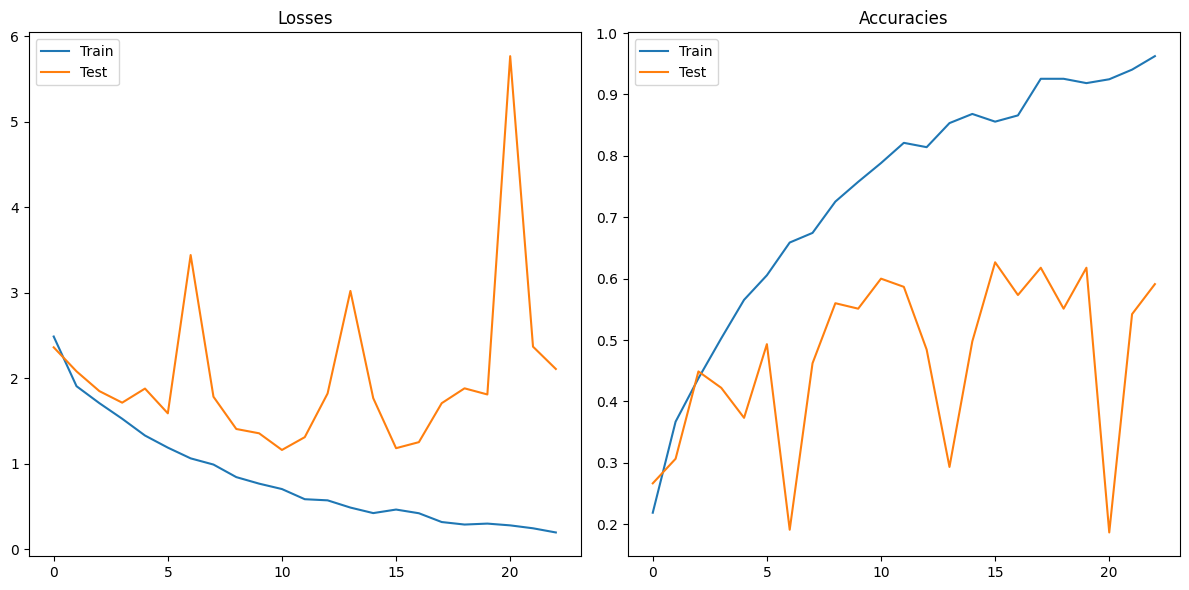

In [49]:
for statistic in statistics:
    plot_statistics(statistic)

Test Loss: 1.5827910900115967
Test Accuracy: 0.5862646698951721


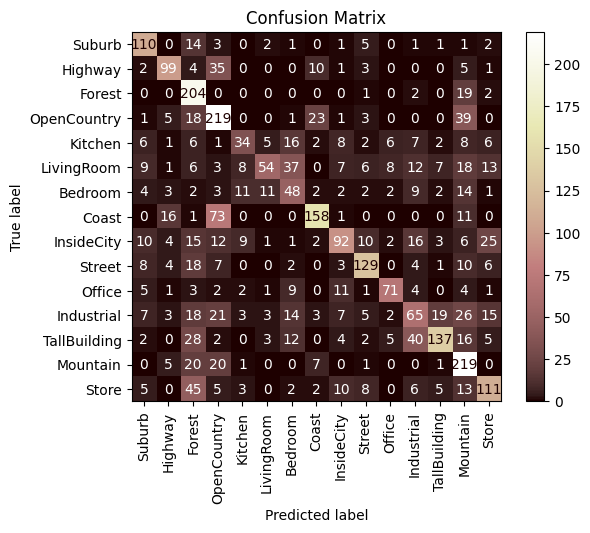

In [50]:
test_model(model, test_loader, criterion)

# Exercise 3

In [20]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Lambda(lambda x: x / 255),
    transforms.Normalize(
        mean=[0.4559, 0.4559, 0.4559],             # Normalize with ImageNet mean
        std=[0.2355, 0.2355, 0.2355]               # Normalize with ImageNet std
    )
])
test_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x / 255),
    transforms.Normalize(
        mean=[0.4559, 0.4559, 0.4559],             # Normalize with ImageNet mean
        std=[0.2355, 0.2355, 0.2355]               # Normalize with ImageNet std
    )
])

In [21]:
train_loader, validation_loader, test_loader = customDataloader(transform=[transform, test_transform], batch_size=32, shuffle=True)

## Fine Tuning

In [87]:
model = alexnet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.classifier[6] = th.nn.Linear(4096, 15, bias=True)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.6)

In [88]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=50)

100%|██████████████| 50/50 [01:49<00:00,  2.18s/it, Train Loss=0.625, Test Loss=0.726, Train Acc=0.859, Test Acc=0.791]


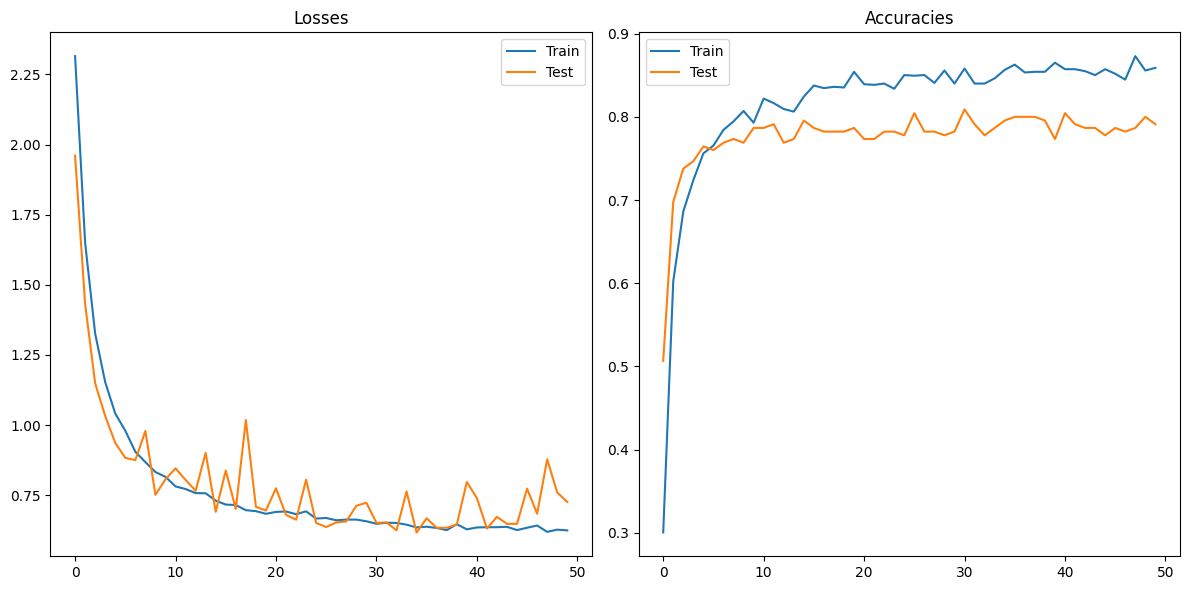

In [89]:
plot_statistics(statistics)

Test Loss: 0.7020344734191895
Test Accuracy: 0.8026800751686096


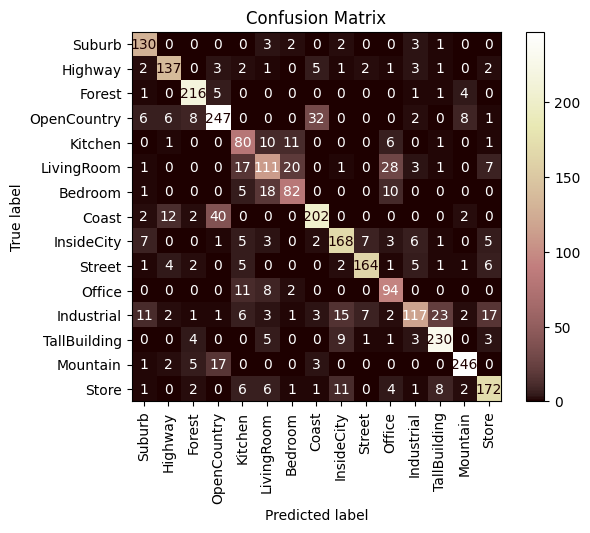

In [90]:
test_model(model, test_loader, criterion)

## SVM

In [22]:
from src.feature_extractor import extract_svm_inputs
DEVICE = th.device("cuda" if th.cuda.is_available() else "cpu")

model = alexnet(pretrained=True).to(DEVICE)
model.eval()

train_data, validation_data, test_data = extract_svm_inputs(model, train_loader, validation_loader, test_loader)

In [23]:
train_data = list(train_data)
train_data[0] = th.cat((train_data[0], validation_data[0]))
train_data[1] = th.cat((train_data[1], validation_data[1]))

In [24]:
from sklearn.svm import LinearSVC

svm = LinearSVC()

In [25]:
svm.fit(train_data[0], train_data[1])

LinearSVC()

In [26]:
y_hat = svm.predict(test_data[0])

In [27]:
from src.plots import custom_confusion_matrix

Accuracy:  0.7688442468643188


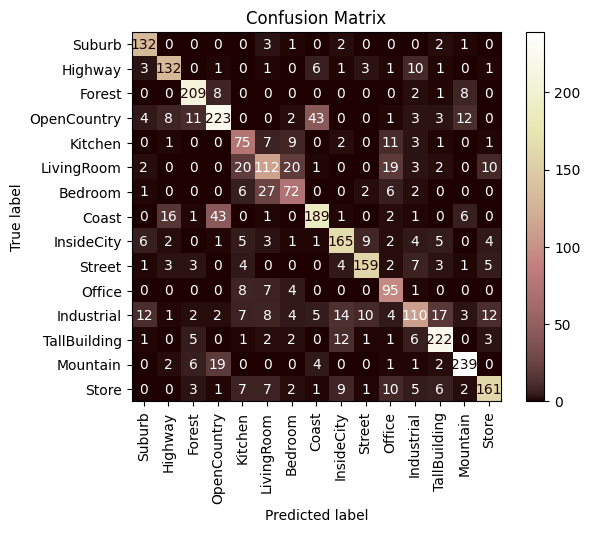

In [28]:
print("Accuracy: ", (test_data[1] == y_hat).float().mean().item())
custom_confusion_matrix(test_data[1], y_hat)

# Exercise 4

## Applied to ex2

In [51]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=0.1)
])
test_transform = None

In [52]:
train_loader, validation_loader, test_loader = customDataloader(transform=[transform, test_transform], batch_size=32, shuffle=True, crop=True)

In [53]:
model = Model(kernel_size=3, normalization=True, dropout=True)
model.net.apply(init_weights)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.5)

In [54]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=100, early_stopping=True)

 81%|████████████▉   | 81/100 [01:15<00:17,  1.08it/s, Train Loss=1.93, Test Loss=2.65, Train Acc=0.39, Test Acc=0.151]

Stopped early, epoch: 81


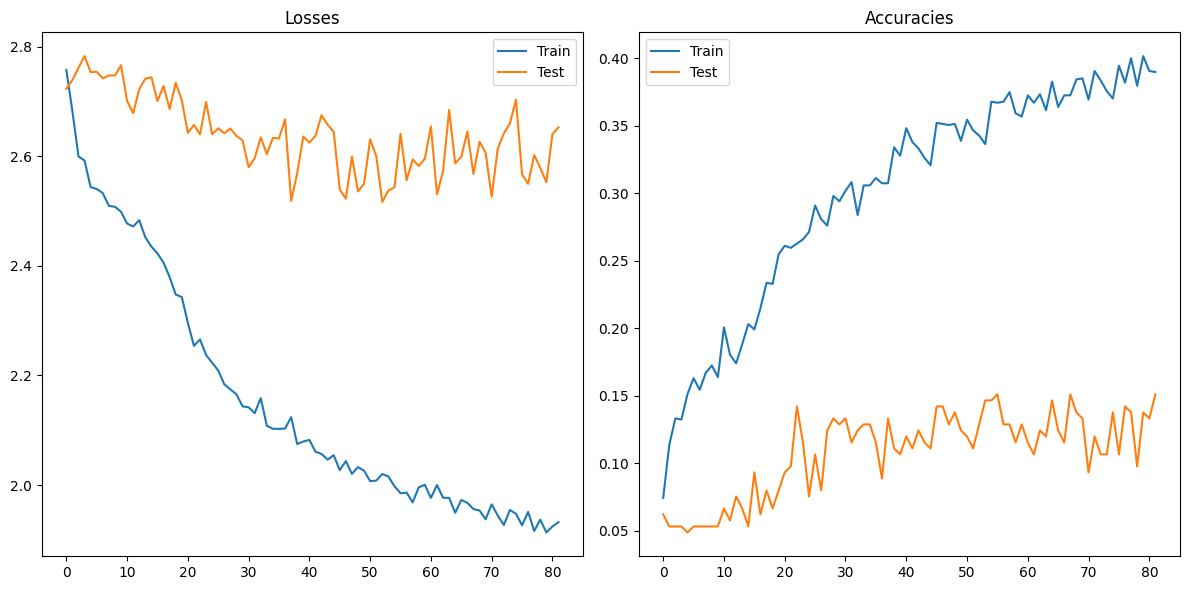

In [55]:
plot_statistics(statistics)

Test Loss: 2.6173315048217773
Test Accuracy: 0.146398663520813


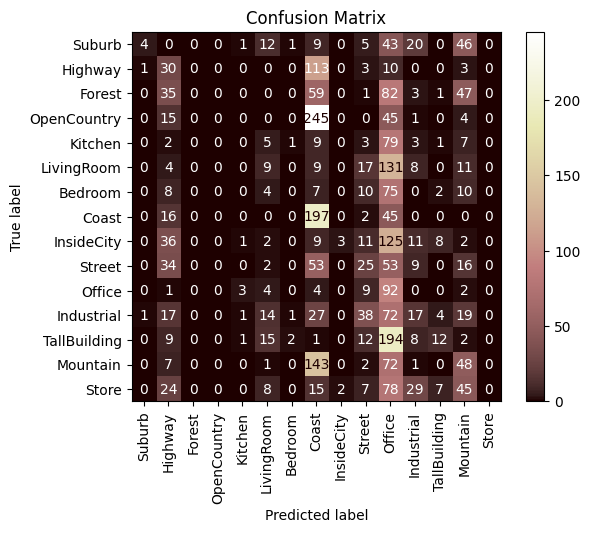

In [56]:
test_model(model, test_loader, criterion)

## Applied to ex3

In [22]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=0.1),
    transforms.Lambda(lambda x: x / 255),
    transforms.Normalize(
        mean=[0.4559, 0.4559, 0.4559],             # Normalize with ImageNet mean
        std=[0.2355, 0.2355, 0.2355]               # Normalize with ImageNet std
    )
])
test_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x / 255),
    transforms.Normalize(
        mean=[0.4559, 0.4559, 0.4559],             # Normalize with ImageNet mean
        std=[0.2355, 0.2355, 0.2355]               # Normalize with ImageNet std
    )
])

In [23]:
train_loader, validation_loader, test_loader = customDataloader(transform=[transform, test_transform], batch_size=32, shuffle=True, crop=True)

In [30]:
model = alexnet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.classifier[6] = th.nn.Linear(4096, 15, bias=True)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)

In [31]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=50)

100%|███████████████| 50/50 [03:33<00:00,  4.26s/it, Train Loss=0.841, Test Loss=1.57, Train Acc=0.795, Test Acc=0.489]


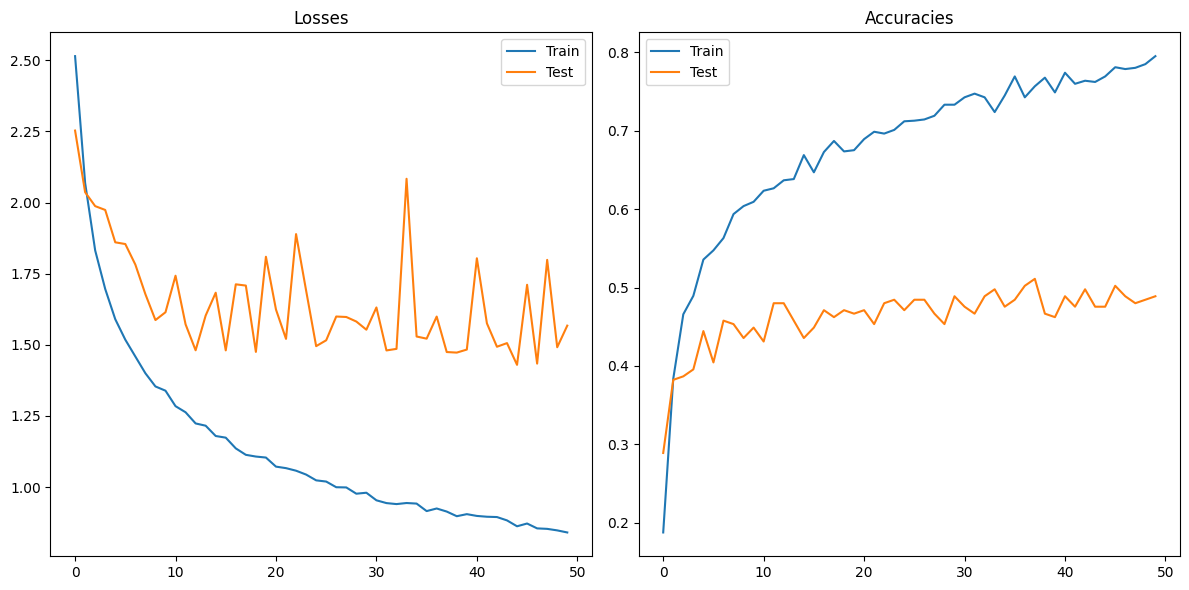

In [32]:
plot_statistics(statistics)

Test Loss: 1.3798540830612183
Test Accuracy: 0.5172529220581055


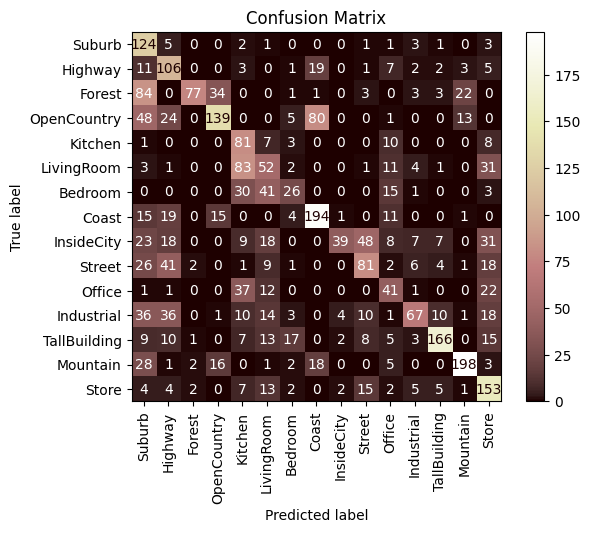

In [33]:
test_model(model, test_loader, criterion)

# Exercise 5

In [57]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=0.1)
])
test_transform = None

In [58]:
train_loader, validation_loader, test_loader = customDataloader(transform=[transform, test_transform], batch_size=32, shuffle=True, crop=True)

In [59]:
model = Model(kernel_size=3, normalization=True, dropout=True, additional=True)
model.net.apply(init_weights)

criterion = th.nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters(), lr=1e-4)

In [60]:
statistics = train_loop(model, train_loader, validation_loader, criterion, optimizer, num_epochs=200, early_stopping=True)

 52%|███████▉       | 105/200 [01:39<01:30,  1.05it/s, Train Loss=2.03, Test Loss=2.4, Train Acc=0.295, Test Acc=0.147]

Stopped early, epoch: 105


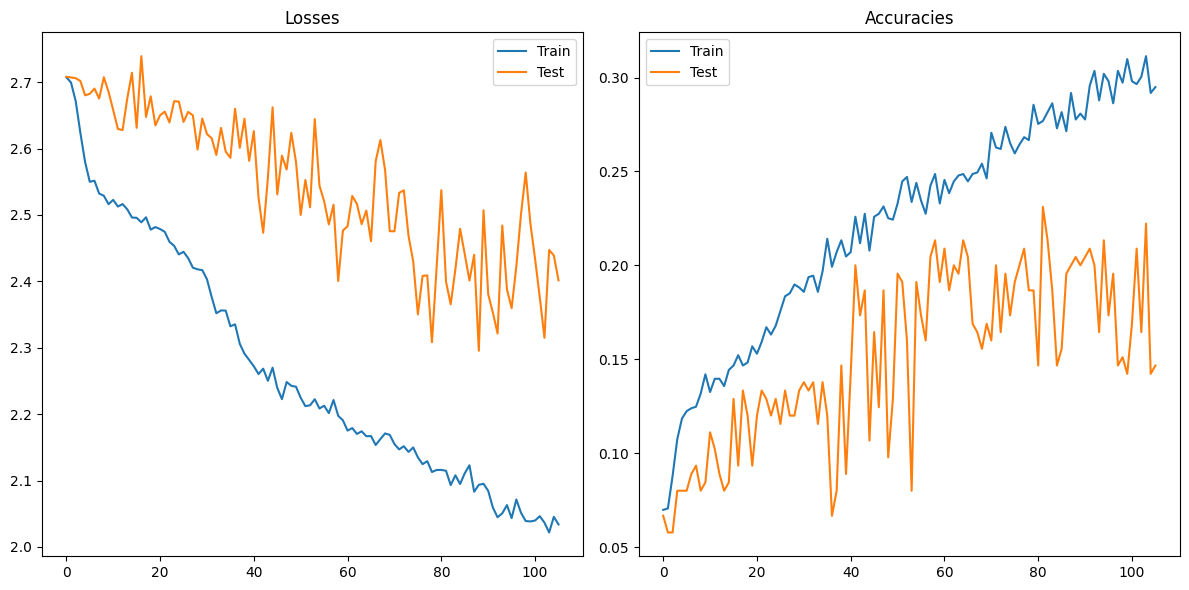

In [61]:
plot_statistics(statistics)

Test Loss: 2.484482765197754
Test Accuracy: 0.1597989946603775


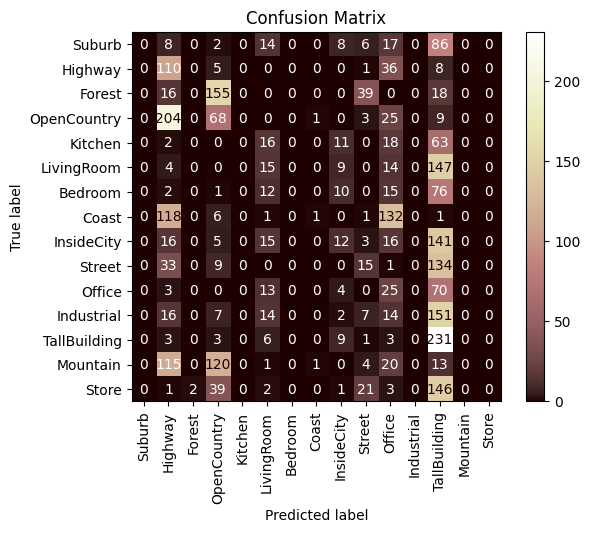

In [62]:
test_model(model, test_loader, criterion)

# Exercise 6

In [3]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Lambda(lambda x: x / 255),
    transforms.Normalize(
        mean=[0.4559, 0.4559, 0.4559],             # Normalize with ImageNet mean
        std=[0.2355, 0.2355, 0.2355]               # Normalize with ImageNet std
    )
])
test_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x / 255),
    transforms.Normalize(
        mean=[0.4559, 0.4559, 0.4559],             # Normalize with ImageNet mean
        std=[0.2355, 0.2355, 0.2355]               # Normalize with ImageNet std
    )
])

In [4]:
train_loader, validation_loader, test_loader = customDataloader(transform=[transform, test_transform], batch_size=32, shuffle=True)

In [5]:
from src.feature_extractor import extract_svm_inputs
DEVICE = th.device("cuda" if th.cuda.is_available() else "cpu")

model = alexnet(pretrained=True).to(DEVICE)
model.eval()

train_data, validation_data, test_data = extract_svm_inputs(model, train_loader, validation_loader, test_loader)

/orfeo/cephfs/home/dssc/stumino/projects/CV/Project/lib64/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/orfeo/cephfs/home/dssc/stumino/projects/CV/Project/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
train_data = list(train_data)
train_data[0] = th.cat((train_data[0], validation_data[0]))
train_data[1] = th.cat((train_data[1], validation_data[1]))

In [31]:
from sklearn.svm import SVC

linear_svm = SVC(kernel="linear")
rbf_svm    = SVC(kernel="rbf")
poly_svm   = SVC(kernel="poly")

In [32]:
linear_svm.fit(train_data[0], train_data[1])
rbf_svm.fit(train_data[0], train_data[1])
poly_svm.fit(train_data[0], train_data[1])

SVC(kernel='poly')

In [33]:
y_hat_linear = linear_svm.predict(test_data[0])
y_hat_rbf    = rbf_svm.predict(test_data[0])
y_hat_poly   = rbf_svm.predict(test_data[0])

In [34]:
from src.plots import custom_confusion_matrix

Accuracy:  0.7621440291404724


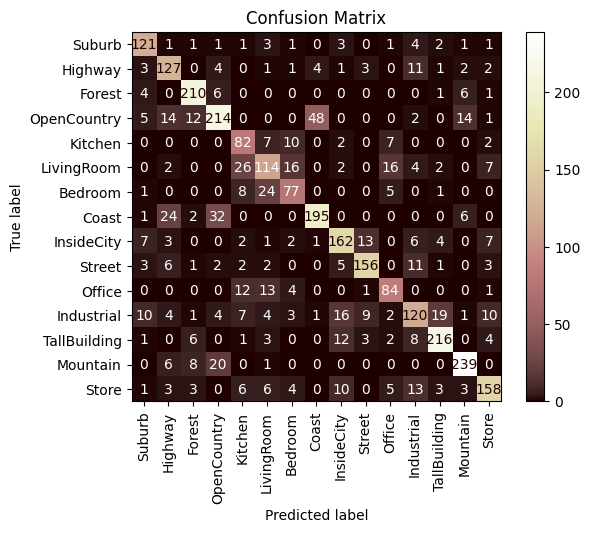

In [35]:
print("Accuracy: ", (test_data[1] == y_hat_linear).float().mean().item())
custom_confusion_matrix(test_data[1], y_hat_linear)

Accuracy:  0.7644891142845154


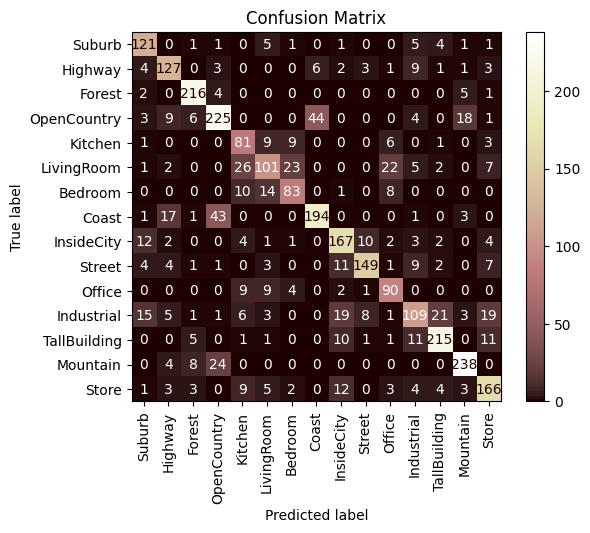

In [36]:
print("Accuracy: ", (test_data[1] == y_hat_poly).float().mean().item())
custom_confusion_matrix(test_data[1], y_hat_poly)

Accuracy:  0.7644891142845154


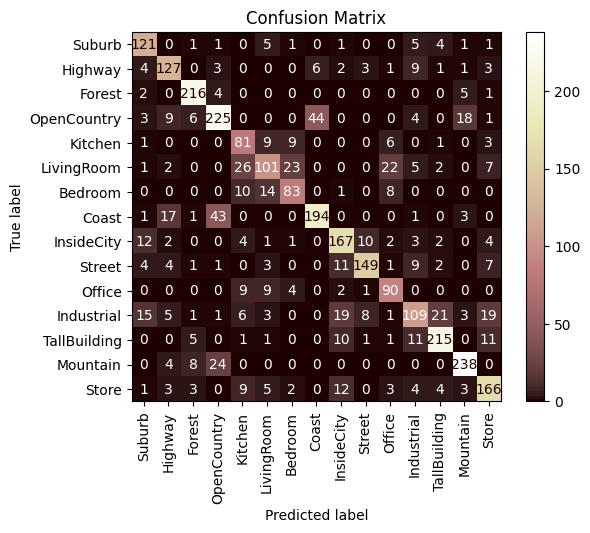

In [37]:
print("Accuracy: ", (test_data[1] == y_hat_rbf).float().mean().item())
custom_confusion_matrix(test_data[1], y_hat_rbf)